In [ ]:
!pip install xgboost

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
iris = load_iris()
X = iris.data  # Features: sepal length, sepal width, petal length, petal width
y = iris.target  # Target: 0 (setosa), 1 (versicolor), 2 (virginica)

# Convert to a pandas DataFrame
data = pd.DataFrame(X, columns=iris.feature_names)
data['target'] = y

In [3]:
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [4]:
# Explore the dataset
print("Dataset Shape:", data.shape)
print("\nFeature Names:", iris.feature_names)
print("\nTarget Names:", iris.target_names)
print("\nFirst 5 rows of the dataset:\n", data.head())

Dataset Shape: (150, 5)

Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Target Names: ['setosa' 'versicolor' 'virginica']

First 5 rows of the dataset:
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Apply StandardScaler to standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled

array([[-1.47393679,  1.20365799, -1.56253475, -1.31260282],
       [-0.13307079,  2.99237573, -1.27600637, -1.04563275],
       [ 1.08589829,  0.08570939,  0.38585821,  0.28921757],
       [-1.23014297,  0.75647855, -1.2187007 , -1.31260282],
       [-1.7177306 ,  0.30929911, -1.39061772, -1.31260282],
       [ 0.59831066, -1.25582892,  0.72969227,  0.95664273],
       [ 0.72020757,  0.30929911,  0.44316389,  0.4227026 ],
       [-0.74255534,  0.98006827, -1.27600637, -1.31260282],
       [-0.98634915,  1.20365799, -1.33331205, -1.31260282],
       [-0.74255534,  2.32160658, -1.27600637, -1.44608785],
       [-0.01117388, -0.80864948,  0.78699794,  0.95664273],
       [ 0.23261993,  0.75647855,  0.44316389,  0.55618763],
       [ 1.08589829,  0.08570939,  0.55777524,  0.4227026 ],
       [-0.49876152,  1.87442714, -1.39061772, -1.04563275],
       [-0.49876152,  1.4272477 , -1.27600637, -1.31260282],
       [-0.37686461, -1.47941864, -0.01528151, -0.24472256],
       [ 0.59831066, -0.

Convert Data to DMatrix
Explanation:

We convert the scaled training and testing data to DMatrix format, which is required for XGBoost’s native API, including xgb.train and xgb.cv.

Why this step is required:

DMatrix optimizes data for XGBoost’s computations, ensuring efficiency and compatibility with its native functions.

In [7]:
# Convert scaled data to DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

In [12]:
dtrain

In [8]:
# Define default parameters for baseline model
default_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'mlogloss',
    'seed': 42
}

In [13]:
# Train the initial model
num_rounds = 100
initial_model = xgb.train(default_params, dtrain, num_rounds)

In [14]:
# Make predictions with the initial model
y_pred_initial = initial_model.predict(dtest)

In [15]:
# Evaluate the initial model
accuracy_initial = accuracy_score(y_test, y_pred_initial)

In [16]:
accuracy_initial

1.0

In [17]:
print("\nInitial Model Classification Report:\n", classification_report(y_test, y_pred_initial, target_names=iris.target_names))



Initial Model Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [18]:
tuning_options = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3]
}

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, subsample=0.8, colsample_bytree=0.8, eval_metric='mlogloss', seed=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=tuning_options, cv=5, scoring='accuracy', n_jobs=-1)

In [19]:
grid_search.fit(X_train_scaled, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.1, 0.3], 'max_depth': [3, 5]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softmax'


In [20]:
best_params = grid_search.best_params_
print("Best Settings:", best_params)

Best Settings: {'learning_rate': 0.1, 'max_depth': 3}


In [21]:
# Convert settings for DMatrix training
train_params = {
    'objective': 'multi:softmax', 'num_class': 3, 'max_depth': best_params['max_depth'],
    'eta': best_params['learning_rate'], 'subsample': 0.8, 'colsample_bytree': 0.8,
    'eval_metric': 'mlogloss', 'seed': 42
}
num_rounds = 100

In [22]:
#Retrain with best settings
tuned_model = xgb.train(train_params, dtrain, num_boost_round=num_rounds)

In [23]:
# Evaluate tuned model
y_pred_tuned = tuned_model.predict(dtest)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("Tuned Model Accuracy:", accuracy_tuned)
print("\nTuned Model Detailed Results:\n", classification_report(y_test, y_pred_tuned, target_names=iris.target_names))

Tuned Model Accuracy: 1.0

Tuned Model Detailed Results:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



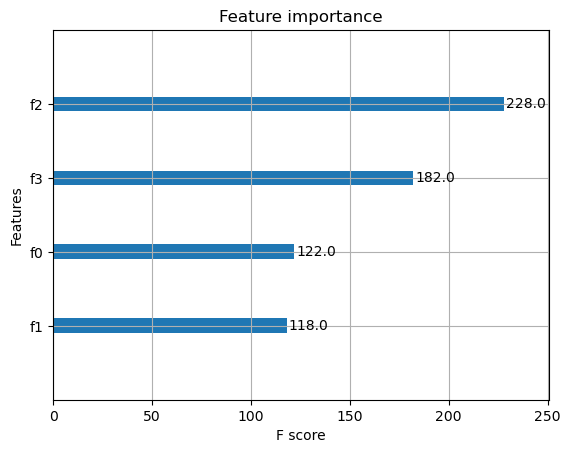

In [24]:
#Visualize feature importance
xgb.plot_importance(tuned_model)
plt.show()